## Snowpack Temperature Model

This notebook implements a multi-layer 1D snowpack temperature model. This uses the following:
- **Heat conduction**: Calculated between snow layers.
- **Shortwave (SW) radiation**: Absorption at the surface using a two band method to separate difference absorption between visible and near infrared wavelengths. SWin is from measured data. SWout is either measured or can be idealized with an albedo constant.
- **Longwave (LW) radiation**: This can used measured LWin or idealized LWin. Observed LWout is used to compare surface temperature. 
- **Turbulent heat fluxes**:  These are calculated at the surface for all scenarios using idealized equations that use measured data. 
- **Melt/refreeze**: This uses a simple "latent cooling" clamp whenever snow temperature rises above 0 °C. The model does not account for melt water or change the layering due to any melting. 

Thi uses Python’s solve_ivp (Runge-Kutta 45) to integrate in time, and we compare the results with observed surface temperatures from meteorological data.

The first cell imports necessary libraries and should run smoothing with the class environment. 


In [2]:
import numpy as np
import math
from math import erf, sqrt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display
import ipywidgets as widgets
import datetime
import pandas as pd

## Constants and Parameters 

This sets the constants and parameters for the model. Many of these are constants or selected based general conditions for snow and air at the elevation of the location. There are additional True / False parameters that allow adjusting of the code to test different modeling.

**File Path** must be changed for variable 'filename' to make the model run.


In [3]:
# Data location 
filename = "/Users/austinfinnell/Documents/GitHub/snowtempprofile/beck_collect.txt"

# Constants and Parameters
sigma    = 5.67e-8          # Stefan-Boltzmann constant
Lv_subl  = 2.83e6           # Latent heat of sublimation (J/kg)
z_ref    = 10               # Reference height (m) for measurements
Lf       = 3.34e5           # Latent heat of fusion (J/kg)
CH = 0.002                  # Sensible heat transfer coefficient 
CE = 0.002                  # Latent heat transfer coefficient
mph_to_ms = 0.44704         # Conversion factor from mph to m/s

# Snowpack parameters 
N = 35                      # Number of layers
snow_depth_m = 1.5          # Total snow depth (m)
eps_snow   = 0.97           # Snow emissivity
c_snow = 2100.0             # Snow specific heat capacity (J/kg.K)
rho_snow = 200.0            # Snow density (kg/m^3)
alpha_snow = 0.80           # albedo of snow surface
k        = 0.2              # Snow thermal conductivity (W/m.K)

# Air parameters
rho_air = 0.84              # Air density (kg/m^3) for 12k ft in CO 
c_pa     = 1005.0           # Specific heat of air at constant pressure (J/kg.K)
p_air = 65000               # Air pressure (Pa) fpr 12,000 ft elevation

# Integration parameters
use_twoBand = True               # If True, use two-band SW absorption approach
use_idealized_LWin = True        # If True, use idealized LW absorption approach and if False, use the measured LW
use_idealized_SWout = True       # If True, use idealized SW absorption approach and if False, use the measured SW
show_plots = True                # If True, show plots of meteorological data
generate_animation = True        # If True, show animation of snowpack evolution. Time consuming. 
n_days = 10                      # numbers of days
dt_max = 1800                    # maximum time step (seconds)
t_end = n_days*24*3600           # end time (seconds)


## Meteorological Data 

This reads in a text file 'beck_collect.txt' which has observations for air temperature, dew point, humidity, wind speed, radiation, and snow surface temperature. This is a text file that is compiled data from the Colorado Avalanche Information Center (CAIC) and the USGS from January 11th to January 21st 2025. 

- **File Format**: The code expects lines in the format:  
  YYYY Mon DD HH:MM Temp(F) MxTp MnTp Dew(F) RH(%) Spd Dir Gst SWIN SWOUT LWIN LWOUT NET [USGS_Tsurf(°C)]
- **Rolling Mean**: A rolling mean with a specified window window_size to smooth out short-term fluctuations.
- **Change Units**: Converts mph measured to m/s. 
- **LWout to surface temp**: Converts LW out to surface temp in K and C to help compare measured surface temp to radiation data for two sources of surface temperature to check for error in measurements. 
- **Interpolate**: The data is then interpolated in time to create continuous values for all times for the solver to use. 


In [4]:

def read_data(filename):
    """
    Expects lines of the form:
      YYYY Mon DD HH:MM  Temp(F) MxTp MnTp Dew(F) RH(%) Spd Dir Gst SWIN SWOUT LWIN LWOUT NET [USGS_Tsurf(°C)]
    For example:
      2025 Jan 21 00:00  -6  -6  -15  -17  60  17  323  26  0  0  98  202  -104  -28.00
    Columns (0-based indexing):
      0=Year,1=Month,2=Day,3=HH:MM,
      4=Temp(F),5=MxTp,6=MnTp,7=Dew(F),8=RH,9=Spd(mph),10=Dir,11=Gst(mph),12=SWIN,13=SWOUT,14=LWIN,15=LWOUT,16=NET,
      17 (optional)=USGS surface T (°C)
    """
    month_map = {
        'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
        'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12
    }

    times_list       = []
    T_airF_list      = []
    dew_list         = []
    RH_list          = []
    wind_spd_list    = []
    SW_in_list       = []
    SW_out_list      = []
    LW_in_list       = []
    LW_out_list      = []
    NET_list         = []
    usgs_list        = []

    earliest_time = None

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            # Expect at least the original 17 tokens.
            if len(parts) < 17:
                continue

            # date/time parsing
            year_str, month_str, day_str = parts[0], parts[1], parts[2]
            hhmm_str = parts[3]
            try:
                year  = int(year_str)
                month = month_map[month_str]
                day   = int(day_str)
            except ValueError:
                continue

            hh_part, mm_part = hhmm_str.split(':')
            hour_24 = int(hh_part)
            minute  = int(mm_part)
            if hour_24 == 24:
                hour_24 = 0
                date_obj = datetime.datetime(year, month, day) + datetime.timedelta(days=1)
                year, month, day = date_obj.year, date_obj.month, date_obj.day

            row_time = datetime.datetime(year, month, day, hour_24, minute)
            if earliest_time is None or row_time < earliest_time:
                earliest_time = row_time

            try:
                T_valF   = float(parts[4])     
                dew_val  = float(parts[7])     
                rh_val   = float(parts[8])     
                spd_val  = float(parts[9])      
                sw_in    = float(parts[12])
                sw_out   = float(parts[13])
                lw_in    = float(parts[14])
                lw_out   = float(parts[15])
                net_val  = float(parts[16])
            except ValueError:
                continue

            times_list.append(row_time)
            T_airF_list.append(T_valF)
            dew_list.append(dew_val)
            RH_list.append(rh_val)
            wind_spd_list.append(spd_val)
            SW_in_list.append(sw_in)
            SW_out_list.append(sw_out)
            LW_in_list.append(lw_in)
            LW_out_list.append(lw_out)
            NET_list.append(net_val)

            # Read extra USGS column if available
            if len(parts) >= 18:
                try:
                    usgs_val = float(parts[17])
                except ValueError:
                    usgs_val = np.nan
            else:
                usgs_val = np.nan
            usgs_list.append(usgs_val)

    if len(times_list) == 0:
        raise ValueError("No valid data parsed from file.")

    # Convert times to hours since earliest_time
    times_arr = np.zeros(len(times_list))
    for i, t in enumerate(times_list):
        dt = t - earliest_time
        times_arr[i] = dt.total_seconds()/3600.0

    T_airF_arr     = np.array(T_airF_list)
    dew_arr        = np.array(dew_list)
    RH_arr         = np.array(RH_list)
    wind_spd_arr   = np.array(wind_spd_list)
    SW_in_arr      = np.array(SW_in_list)
    SW_out_arr     = np.array(SW_out_list)
    LW_in_arr      = np.array(LW_in_list)
    LW_out_arr     = np.array(LW_out_list)
    NET_arr        = np.array(NET_list)
    usgs_arr       = np.array(usgs_list)

    # sort chronologically
    idx_sort = np.argsort(times_arr)
    times_arr    = times_arr[idx_sort]
    T_airF_arr   = T_airF_arr[idx_sort]
    dew_arr      = dew_arr[idx_sort]
    RH_arr       = RH_arr[idx_sort]
    wind_spd_arr = wind_spd_arr[idx_sort]
    SW_in_arr    = SW_in_arr[idx_sort]
    SW_out_arr   = SW_out_arr[idx_sort]
    LW_in_arr    = LW_in_arr[idx_sort]
    LW_out_arr   = LW_out_arr[idx_sort]
    NET_arr      = NET_arr[idx_sort]
    usgs_arr     = usgs_arr[idx_sort]

    return (times_arr, T_airF_arr, dew_arr, RH_arr, wind_spd_arr,
            SW_in_arr, SW_out_arr, LW_in_arr, LW_out_arr, NET_arr, usgs_arr)

# call the function to read the data
times_arr, T_air_arr, dew_arr, RH_arr, wind_spd_arr, sw_in_arr, sw_out_arr, lw_in_arr, lw_out_arr, net_arr, usgs_arr = read_data(filename)

window_size = 3  # size of the rolling window for smoothing
T_air_arr       = pd.Series(T_air_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
dew_arr         = pd.Series(dew_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
RH_arr          = pd.Series(RH_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
wind_spd_arr    = pd.Series(wind_spd_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
sw_in_arr       = pd.Series(sw_in_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
sw_out_arr      = pd.Series(sw_out_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
lw_in_arr       = pd.Series(lw_in_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
lw_out_arr      = pd.Series(lw_out_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
net_arr         = pd.Series(net_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
usgs_arr        = pd.Series(usgs_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

# Calculate the surface temperature from the measured LW out
lw_out_surf_temp_K = (lw_out_arr / (eps_snow * sigma))**0.25
lw_out_surf_temp_C = lw_out_surf_temp_K - 273.15
times_sec = times_arr * 3600
surf_temp_obs_interp = interp1d(times_sec, lw_out_surf_temp_C, kind='linear', fill_value='extrapolate')

# convert wind speed from mph to m/s
wind_ms_arr = wind_spd_arr * mph_to_ms

T_airF_interp  = interp1d(times_sec, T_air_arr,  kind='linear', fill_value='extrapolate')
dew_arr_interp = interp1d(times_sec, dew_arr,     kind='linear', fill_value='extrapolate')
RH_arr_interp  = interp1d(times_sec, RH_arr,      kind='linear', fill_value='extrapolate')
wind_interp    = interp1d(times_sec, wind_ms_arr, kind='linear', fill_value='extrapolate')
SW_in_interp   = interp1d(times_sec, sw_in_arr,   kind='linear', fill_value='extrapolate')
SW_out_interp  = interp1d(times_sec, sw_out_arr,  kind='linear', fill_value='extrapolate')
LW_in_interp   = interp1d(times_sec, lw_in_arr,   kind='linear', fill_value='extrapolate')
LW_out_interp  = interp1d(times_sec, lw_out_arr,  kind='linear', fill_value='extrapolate')
usgs_temp_obs_interp = interp1d(times_sec, usgs_arr, kind='linear', fill_value='extrapolate')


## Plotting Measured Data

If show_plots is set to True, this produces three plots that help to visualize and assess the data for quality. 

**Surface Temperature (LW-derived vs. USGS)**: 
   - LW_out-derived surface temperature: computed by inverting the Stefan-Boltzmann equation from measured longwave radiation.
   - USGS surface temperature is measured at the site. 
   - This could be used in the future because some locations only have radiation data, but no surface temperature. Conversely, a manual measurement of the snow surface is the easiest measurement to take. This helps confirm that either route for validation could be useful and in sync in the future depending on data source. 

**Air and Dewpoint Temperature in Deg F with Relative Humidity**

**Radiation Data**: 
   - SW_in: incoming shortwave
   - SW_out: reflected shortwave from the snow surface
   - LW_in: downwelling longwave from the atmosphere
   - LW_out: (upwelling longwave from the snow surface

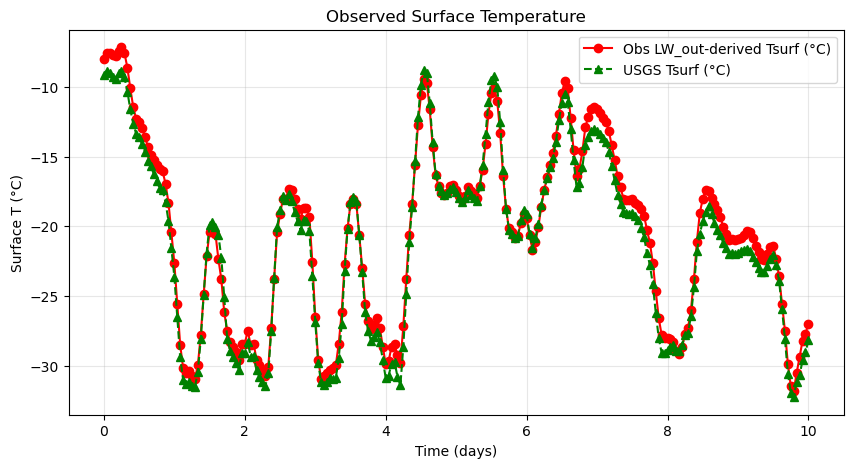

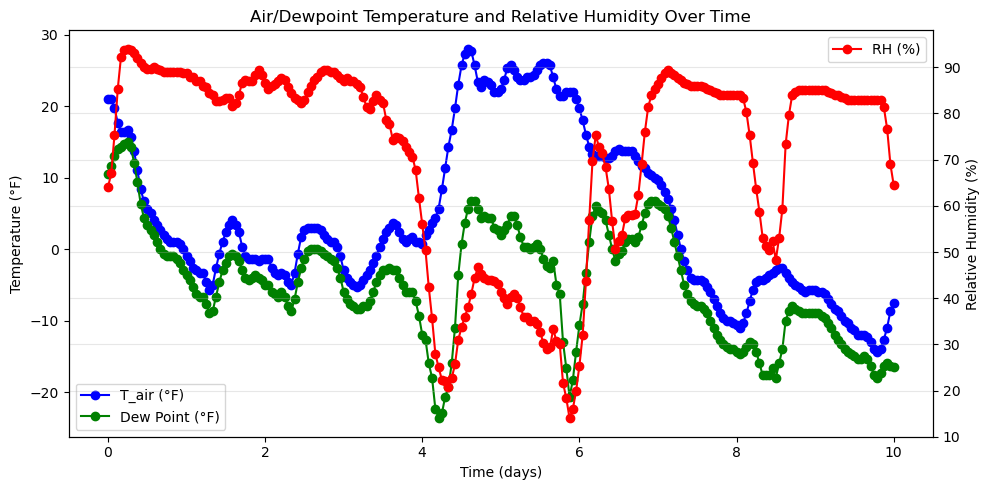

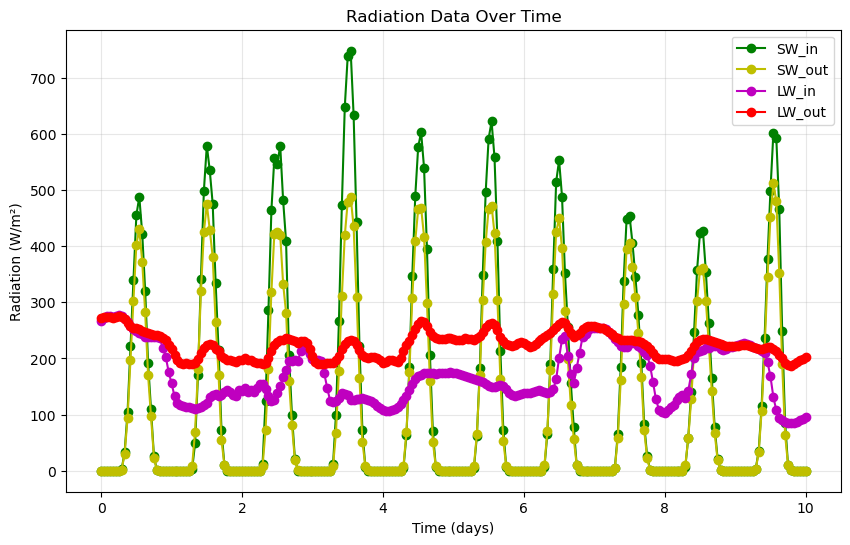

In [5]:

# Plot observed data if True 

if show_plots:
    # Check if the time range exceeds 72 hours
    max_time = times_arr.max()
    use_days = max_time > 72  # Use days if more than 72 hours
    
    # Plot the observed surface temperature from LW_out-derived and USGS data
    plt.figure(figsize=(10, 5))
    if use_days:
        plt.plot(times_arr/24, lw_out_surf_temp_C, 'ro-', label='Obs LW_out-derived Tsurf (°C)')
        plt.plot(times_arr/24, usgs_arr, 'g^--', label='USGS Tsurf (°C)')
        plt.xlabel("Time (days)")
    else:
        plt.plot(times_arr, lw_out_surf_temp_C, 'ro-', label='Obs LW_out-derived Tsurf (°C)')
        plt.plot(times_arr, usgs_arr, 'g^--', label='USGS Tsurf (°C)')
        plt.xlabel("Time (hours)")
    plt.ylabel("Surface T (°C)")
    plt.title("Observed Surface Temperature")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # Plot the air/dewpoint temperature over time
    fig, ax1 = plt.subplots(figsize=(10, 5))
    if use_days:
        ax1.plot(times_arr/24, T_air_arr, 'bo-', label='T_air (°F)')
        ax1.plot(times_arr/24, dew_arr, 'go-', label='Dew Point (°F)')
        ax1.set_xlabel("Time (days)")
    else:
        ax1.plot(times_arr, T_air_arr, 'bo-', label='T_air (°F)')
        ax1.plot(times_arr, dew_arr, 'go-', label='Dew Point (°F)')
        ax1.set_xlabel("Time (hours)")
    ax1.set_ylabel("Temperature (°F)")
    ax1.tick_params(axis='y')
    ax1.legend(loc='lower left')

    # Add secondary y-axis for relative humidity
    ax2 = ax1.twinx()
    if use_days:
        ax2.plot(times_arr/24, RH_arr, 'ro-', label='RH (%)')
    else:
        ax2.plot(times_arr, RH_arr, 'ro-', label='RH (%)')
    ax2.set_ylabel("Relative Humidity (%)")
    ax2.legend(loc='upper right')

    plt.title("Air/Dewpoint Temperature and Relative Humidity Over Time")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot the radiation data
    plt.figure(figsize=(10, 6))
    if use_days:
        plt.plot(times_arr/24, sw_in_arr, 'go-', label='SW_in')
        plt.plot(times_arr/24, sw_out_arr, 'yo-', label='SW_out')
        plt.plot(times_arr/24, lw_in_arr, 'mo-', label='LW_in')
        plt.plot(times_arr/24, lw_out_arr, 'ro-', label='LW_out')
        plt.xlabel("Time (days)")
    else:
        plt.plot(times_arr, sw_in_arr, 'go-', label='SW_in')
        plt.plot(times_arr, sw_out_arr, 'yo-', label='SW_out')
        plt.plot(times_arr, lw_in_arr, 'mo-', label='LW_in')
        plt.plot(times_arr, lw_out_arr, 'ro-', label='LW_out')
        plt.xlabel("Time (hours)")
    plt.ylabel("Radiation (W/m²)")
    plt.title("Radiation Data Over Time")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

## Snow Layer Construction

To represent the snowpack, it is divided into **N** layers. For each layer, the following variables are defined:
- **z_F**: The depth at each “face” of a layer (top and bottom boundaries). There are *N+1* such faces.
- **z_T**: The midpoint depth of each layer. These midpoints are where snow temperature is stored and tracked.
- **dz**: This is the thickness of each layer variable. 
- **H**: This is the height of the snowpack and should match the set snow depth variable created. 

This is printed for reference and confirming of values. 

In [6]:
# Divides the snowpack into N layers
# Temperatures are stored at the midpoints of each layer (z_T)
# The faces of the layers are stored in z_F array
# z_F has N+1 elements, z_T has N elements

z_F = np.linspace(0.0, snow_depth_m, N+1)   # N+1 faces for N layers
z_T = 0.5*(z_F[:-1] + z_F[1:])              # Layer midpoints
dz  = z_F[1:] - z_F[:-1]                    # Thickness of each layer
H   = z_F[-1]                               # Should match snow_depth_m

print(f"Snow Depth = {H:.3f} m with {N} layers; each ~{dz[0]:.4f} m thick")

Snow Depth = 1.500 m with 35 layers; each ~0.0429 m thick



## Set Initial Temperature Profile

This creates the initial conditions for the model based on the following. 

1. Assume the ground temperature at the bottom boundary is 273.15 K (0 °C).
2. Use the initial surface temperature from the measured LW_out data (converting it to Kelvin).
3. Set two key points in the snowpack (0.2 m below the surface and 0.2 m above the ground) to be halfway (in temperature) between the surface and ground temperatures.
4. Use a PCHIP (piecewise cubic Hermite) interpolator to smoothly transition between these four anchor points.
5. Note that the array z_T runs from bottom (0 m) to top ('H' m). To match our physical assumption of x being 0 at the surface, we transform the depth coordinates as x_vals = H - z_T.

This creates an initial condition for snow temperature (T_init) that smoothly ramps from the observed surface value to 0 °C at the bottom. This is to start the initial conditions to more closely match a realistic snow profile. Below is a graphic from the US Army Corps of Engineers Hydrologic Engineering Center from their documentation on one of their water and snow melt models. 

![Temperature profile visualization](https://www.hec.usace.army.mil/confluence/hmsdocs/hmstrm/files/54662725/58623667/1/1619566409276/image2021-4-27_16-33-29.png)

(https://www.hec.usace.army.mil/confluence/hmsdocs/hmstrm/files/54662725/58623667/1/1619566409276/image2021-4-27_16-33-29.png)


In [7]:

T_ground   = 273.15
T_snow_min = lw_out_surf_temp_K[0]  
H          = snow_depth_m           

#   Surface (x = 0): T = T_snow_min.
#   0.2 m below the surface (x = 0.2): T = (T_snow_min + T_ground)/2.
#   0.2 m above the ground (x = H - 0.2): T = (T_snow_min + T_ground)/2.
#   Ground (x = H): T = T_ground.

x_key = np.array([0, 0.2, H - 0.2, H])
T_key = np.array([T_snow_min, (T_snow_min + T_ground) / 2.0, (T_snow_min + T_ground) / 2.0, T_ground])

# Create a PCHIP interpolator using these key points
pchip = PchipInterpolator(x_key, T_key)

# Convert the layer midpoints (z_T) into the x coordinate (distance from surface)
# Note: z_T is defined from 0 at the bottom to H at the top, so we use:
x_vals = H - z_T  # x = 0 at surface, x = H at ground

# Compute the initial temperature profile 
T_init = pchip(x_vals)
top_index = np.argmax(z_T)
T_init[top_index] = T_snow_min

## Physics Functions for Surface Energy Balance

This cellblock holds the functions for the physics of the energy balance equation for the surface. 

**Atmospheric Properties**
- **Air Temperature:** Converts measured air temperature from Fahrenheit to Kelvin.
- **Wind Speed:** Retrieves wind speed data (m/s) and leaves room to adjust.
- **Specific Humidity:** Calculates water vapor content of the air based on temperature and relative humidity using the Tetens formula to use in the latent heat calculation.

**Energy Balance Components**
- **Radiative Fluxes:** Calculates the net balance of incoming and outgoing radiation at the snow surface, using either measured data or idealized approximations.
- **Turbulent Fluxes:** Computes sensible and latent heat fluxes using wind speed, temperature differences, and humidity gradients, with a stability factor.
- **Shortwave Absorption:** Models how solar radiation penetrates and is absorbed in the snowpack by dividing radiation into visible and near-infrared bands, each with different penetration depths.

**Snowpack Temperature**
- **Heat Conduction and Phase Changes:** Prevents the snow from exceeding 0 deg C and takes into account heat transfer from melting. 

In [8]:
def measured_air_temp(t_sec):
    # Convert measured T_air from F to C to K
    T_F = T_airF_interp(t_sec)
    T_C = (T_F - 32.0)*(5.0/9.0)
    return T_C + 273.15

def get_wind_speed(t_sec):
    # Wind speed is from data and already converted to m/s
    return wind_interp(t_sec) 

def compute_specific_humidity(T_C, RH, p=p_air):
    if T_C >= 0.0:
        e_sat = 611 * np.exp((17.27 * T_C) / (T_C + 237.3))
    else:
        e_sat = 611 * np.exp((22.46 * T_C) / (T_C + 272.62))
    e_act = RH * e_sat
    return (0.622 * e_act) / (p - (0.378 * e_act))

def get_air_specific_humidity(t_sec, p=p_air):
    T_airK = measured_air_temp(t_sec)
    T_airC = T_airK - 273.15
    RH_frac = RH_arr_interp(t_sec) / 100.0  
    return compute_specific_humidity(T_airC, RH_frac, p)

def get_snow_specific_humidity(T_surfK, p=p_air):
    T_surfC = min(T_surfK - 273.15, 0.0)
    e_snow_sat = 611.0 * np.exp((22.46 * T_surfC) / (T_surfC + 272.62))  # Saturation vapor pressure over ice (Pa)
    return (0.622 * e_snow_sat) / (p - (0.378 * e_snow_sat))

def compute_atmospheric_emissivity(t_sec):
    # Use Brutsaert (1975) using specific humidity to calculate emissivity
    # Add in scale factor when RH is high for clouds 
    T_airK = measured_air_temp(t_sec)
    q_air = get_air_specific_humidity(t_sec)

    # Convert q to vapor pressure e (Pa)
    e_pa = q_air * p_air / (0.622 + 0.378 * q_air)
    e_hPa = e_pa / 100.0

    eps_atm = 1.24 * (e_hPa / T_airK)**(1.0/7.0)

    # If RH > 50%, then add scale factor
    rh_val = RH_arr_interp(t_sec)  # in percent
    if rh_val > 50:
        # For example, add up to +0.04 when RH=100%
        # (Linearly scaled between 50% and 100%)
        factor = (rh_val - 50.0) / 50.0  # from 0 at RH=50% up to 1 at RH=100%
        # Maximum offset of +0.04
        eps_atm += 0.06 * min(factor, 1.0)

    # Bound the results to prevent extremes 
    if eps_atm < 0.5:
        eps_atm = 0.5
    elif eps_atm > 1.0:
        eps_atm = 1.0

    return eps_atm

def compute_shortwave_net(t_sec):
    # use_idealized_SW=True: sw_net = SW_in * (1 - alpha_snow)
    # use_idealized_SW=False: sw_net = max(SW_in - SW_out, 0)
   
    sw_in_val  = SW_in_interp(t_sec)
    sw_out_val = SW_out_interp(t_sec)

    if use_idealized_SWout:
        sw_net = sw_in_val * (1.0 - alpha_snow)
    else:
        sw_net = max(sw_in_val - sw_out_val, 0.0)
        
    return sw_net

def turbulent_fluxes(t_sec, T_surfK):
    # Compute sensible and latent heat fluxes
    T_airK = measured_air_temp(t_sec)
    U = get_wind_speed(t_sec)
    U = max(U, 0.1)  # minimum wind speed of 0.1 m/s
    
    # Calculate stability factor
    delta_T = T_airK - T_surfK
    if delta_T >= 0:
        stability_factor = 1.0  # Neutral or unstable conditions
    else:
        # Stable conditions - reduce fluxes as temperature difference increases
        stability_factor = min(1.0, max(0.5, (delta_T / 5)))
    
    # Sensible and latent heat fluxes with stability correction
    Q_sensible = rho_air * c_pa * CH * U * (T_airK - T_surfK) * stability_factor
    q_air = get_air_specific_humidity(t_sec)
    q_snow = get_snow_specific_humidity(T_surfK)
    Q_latent = rho_air * Lv_subl * CE * U * (q_air - q_snow) * stability_factor
    
    return Q_sensible, Q_latent

def compute_radiative_fluxes(t_sec, T_surfK):
    lw_down = LW_in_interp(t_sec)
    lw_up   = eps_snow * sigma * (T_surfK ** 4)
    lw_net  = lw_down - lw_up
    sw_net  = max(SW_in_interp(t_sec) - SW_out_interp(t_sec), 0)
    return lw_net, sw_net

def compute_idealized_radiative_fluxes(t_sec, T_surfK):
    # Idealize LW using atmospheric emissivity set as a constant instead of measured LW 
    T_airK = measured_air_temp(t_sec)
    eps_atm = compute_atmospheric_emissivity(t_sec) # new function add 
    LW_in_ideal = eps_atm * sigma * (T_airK ** 4)
    lw_up = eps_snow * sigma * (T_surfK ** 4)
    lw_net = LW_in_ideal - lw_up
    sw_net = max(SW_in_interp(t_sec) - SW_out_interp(t_sec), 0)
    return lw_net, sw_net

def shortwave_absorption_twoBand(t_sec, z_faces):
    # Splits SW into two bands: near-IR and visible
    # Uses set albedo instead of SW out 
    sw_net = compute_shortwave_net(t_sec)

    # Spectral band fractions (tune if needed)
    f_nir = 0.4  # fraction of SW in near-IR
    f_vis = 1.0 - f_nir

    # Attenuation coefficients (1/m) -- these are e-folding decay rates
    # Adjusted for typical fresh/dry snow: NIR ~2–5 cm, VIS ~10–20 cm
    kappa_nir = 35.0   # shallow: ~2.5 cm e-folding depth
    kappa_vis = 5.0    # deeper: ~14 cm e-folding depth

    # Compute absorption for each band
    sw_nir_top = sw_net * f_nir
    sw_vis_top = sw_net * f_vis

    # Compute depths
    d_faces = H - z_faces
    d_top = d_faces[1:]     # top of each layer
    d_bottom = d_faces[:-1] # bottom of each layer

    # NIR absorption in each layer
    flux_in_nir = sw_nir_top * np.exp(-kappa_nir * d_top)
    flux_out_nir = sw_nir_top * np.exp(-kappa_nir * d_bottom)
    SW_abs_nir = flux_in_nir - flux_out_nir

    # VIS absorption in each layer
    flux_in_vis = sw_vis_top * np.exp(-kappa_vis * d_top)
    flux_out_vis = sw_vis_top * np.exp(-kappa_vis * d_bottom)
    SW_abs_vis = flux_in_vis - flux_out_vis
    
    total_abs = SW_abs_nir + SW_abs_vis

    # Return total absorbed shortwave flux per layer (W/m²)
    return np.maximum(total_abs, 0.0)

def enforce_melt_freeze(T, dTdt, tau=1800):
    # subtract latent cooling from dTdt if T > 273.15
    # tau is the time scale for latent cooling in seconds
    for i in range(len(T)):
        if T[i] > 273.15:
            # Compute latent cooling rate (K/s)
            latent_cooling_rate = (T[i] - 273.15) / tau
            # Subtract the latent cooling from the temperature tendency
            dTdt[i] -= latent_cooling_rate
            if dTdt[i] > 0:
                dTdt[i] = 0
            
    return T, dTdt

## Main dT/dt Equation

This determines the conductive heat exchange between the ground and the lowest snow layer, followed by conductive exchanges between adjacent snow layers based on their temperature differences. Next, it computes energy losses at the snow surface from net radiation and turbulent fluxes (sensible and latent heat). These combined losses establish the energy boundary at the surface. 

This is set up so that a positive F[i] means heat flowing outward from the layer i into i+1. So positive flux at the surface, must be negative so that energy is entering and traveling downward so it must be negative. Shortwave is treated as a internal heating source with each layer and is added to each layer so that it can penetrate into the layers. 

The function evaluates the net energy entering or leaving each snow layer, converting this into temperature changes.  Lastly, it adjusts the temperatures to account for melting or freezing processes, ensuring the values remain physically consistent. The function ultimately returns the calculated temperature change rate (dT/dt) for each layer.


In [9]:


def dT_dt(t_sec, T):
    # Conductive fluxes at layer interfaces
    F = np.zeros(N+1)
    
    # Ground flux 
    F[0] = k * (T_ground - T[0]) / dz[0]
    for i in range(1, N):
        F[i] = k * (T[i-1] - T[i]) / dz[i]
    
    # Choose radiative flux calculation method
    if use_idealized_LWin:
        net_radiative, _ = compute_idealized_radiative_fluxes(t_sec, T[-1])
    else:
        net_radiative, _ = compute_radiative_fluxes(t_sec, T[-1])
    
    # surface flux is negative sign because it is a loss
    Q_sensible, Q_latent = turbulent_fluxes(t_sec, T[-1])
    F[N] = -(net_radiative + Q_sensible + Q_latent)
    
    # Temperature tendency from conduction/fluxes
    dTdt = np.zeros(N)
    for i in range(N):
        dTdt[i] = -(F[i+1] - F[i]) / (rho_snow * c_snow * dz[i])
    
    # Shortwave absorption
    if use_twoBand:
        SW_profile = shortwave_absorption_twoBand(t_sec, z_F)
    else:
        SW_profile = np.zeros(N)
    for i in range(N):
        dTdt[i] += SW_profile[i] / (rho_snow * c_snow * dz[i])
    
    # Apply melt/freeze adjustment
    T, dTdt = enforce_melt_freeze(T, dTdt, tau=1800)
    
    return dTdt




## Comparing Multiple SW/LW Scenarios and Fluxes

This cell runs four different scenarios for shortwave (SW) and longwave (LW) boundary conditions. It then captures each scenario’s surface temperature evolution and surface energy fluxes. The model is solved via solve_ivp, and the results (surface temperatures, radiative fluxes, sensible and latent heat fluxes, and total net energy) are saved in the results dictionary.

This is then plotted:
- **Surface Temperature**: Observed vs scenarios.
- **Energy Fluxes**: in subplots for net radiative, sensible, latent, and overall net energy flux. A sign flip is applied for visualization, so upward fluxes appear positive on the plots.



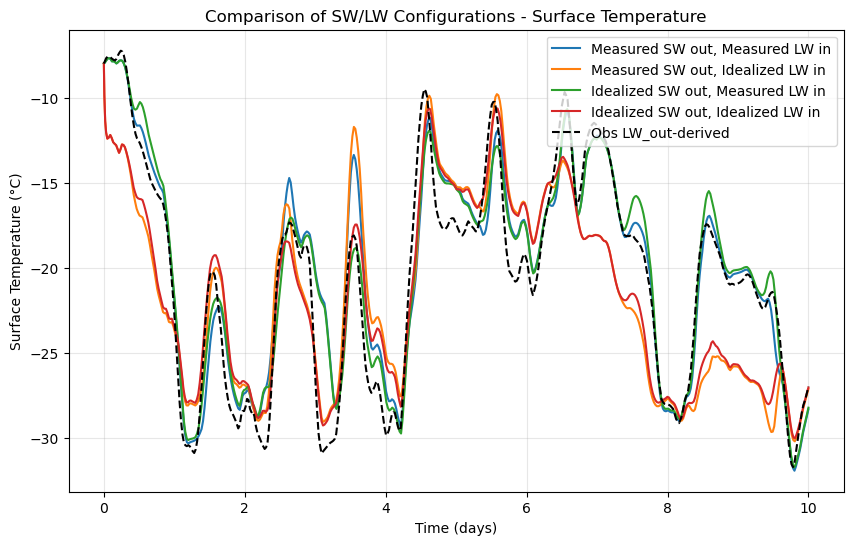

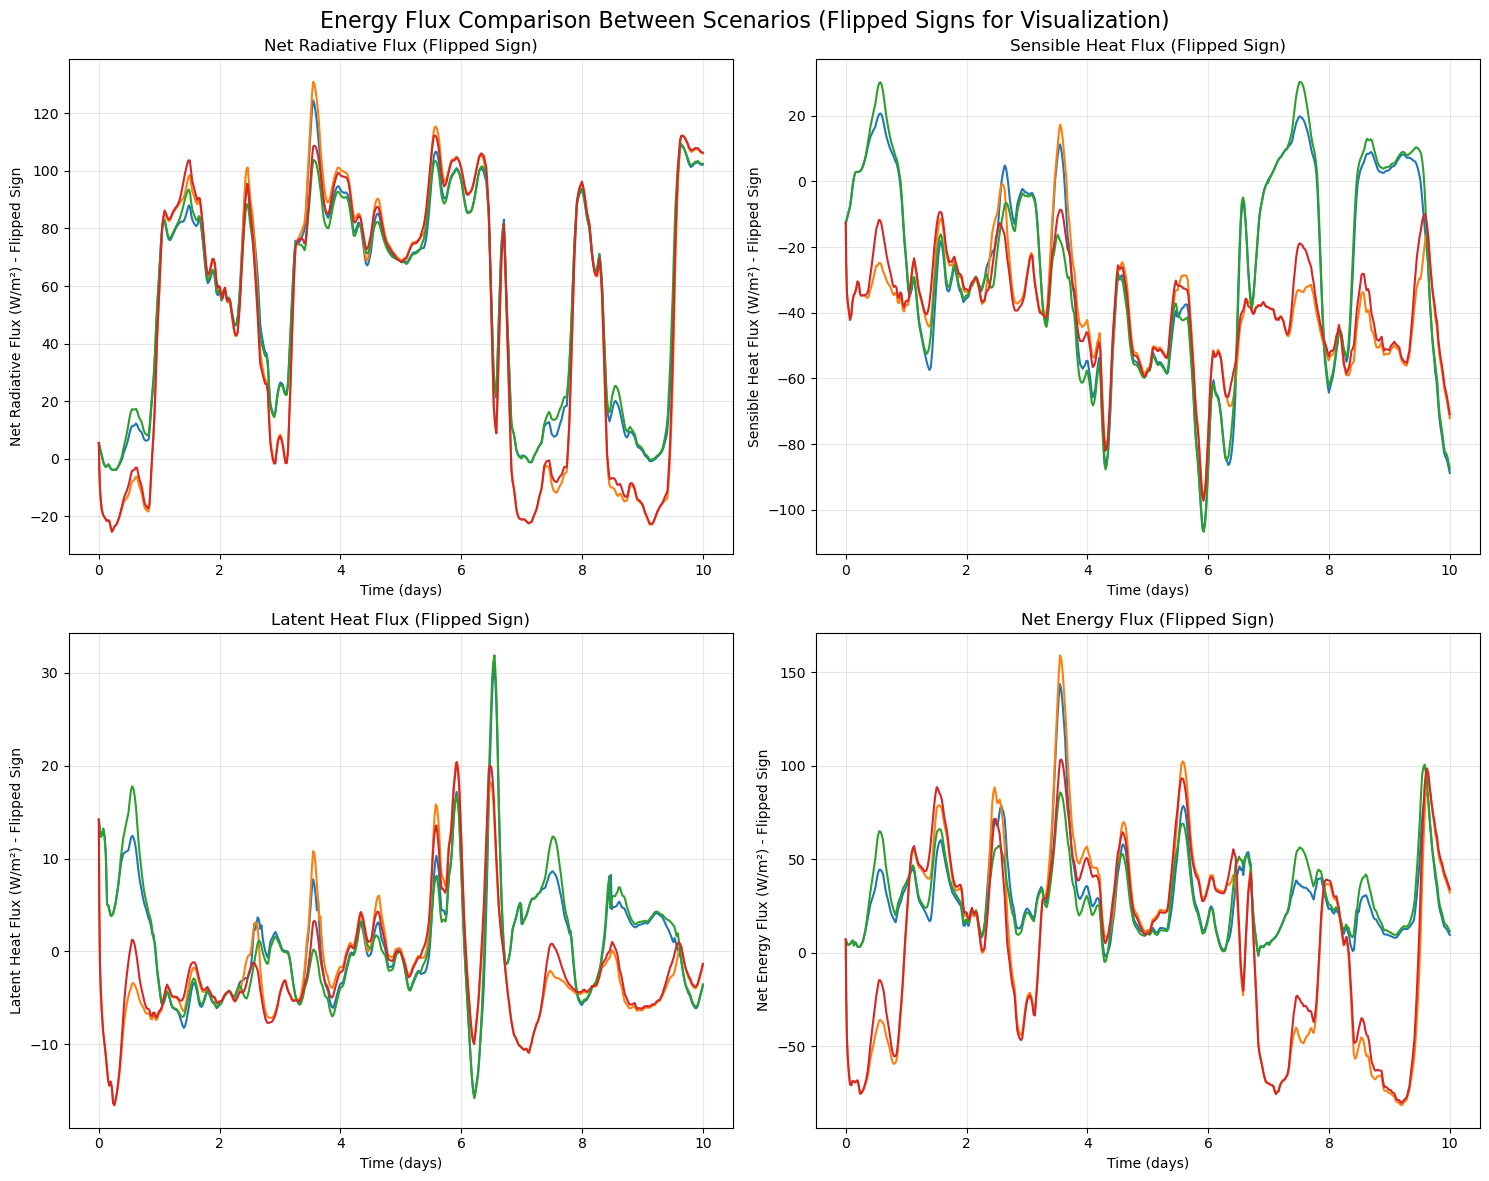

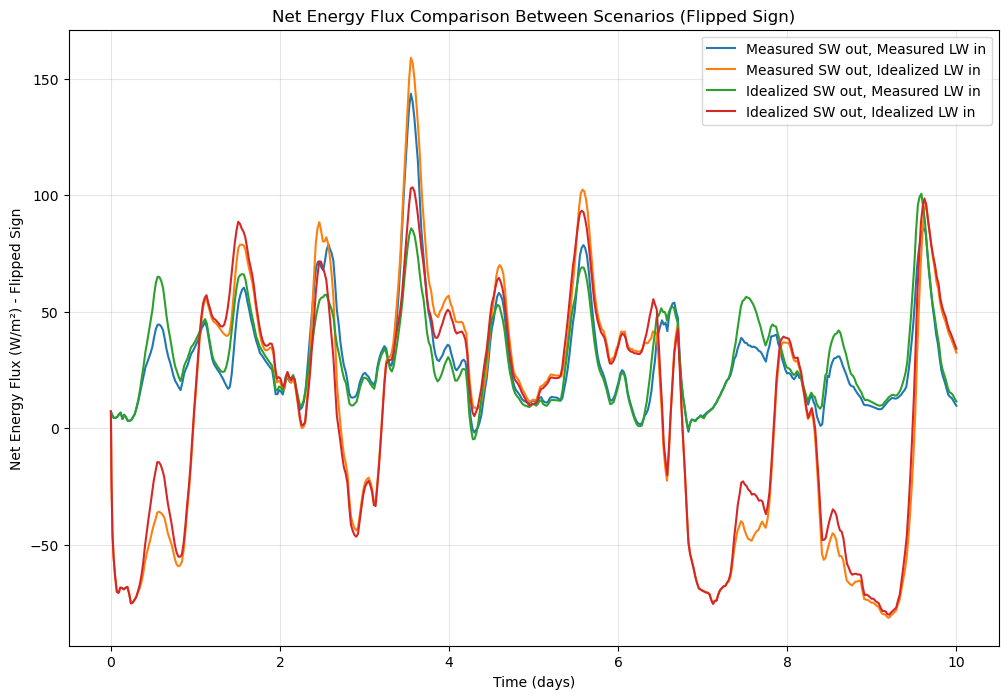

In [10]:
def run_snow_model(use_idealized_SW_local, use_idealized_LW_local):
    # runs solver multiple times with different SW/LW settings
    global use_idealized_SWout, use_idealized_LWin
    old_SW = use_idealized_SWout
    old_LW = use_idealized_LWin

    use_idealized_SWout = use_idealized_SW_local
    use_idealized_LWin = use_idealized_LW_local
    
    sol = solve_ivp(fun=dT_dt,
                    t_span=(0, t_end),
                    y0=T_init,
                    method='RK45',
                    max_step=dt_max,
                    rtol=1e-5,
                    atol=1e-7)
    
    # Restore the original flags
    use_idealized_SWout = old_SW
    use_idealized_LWin = old_LW
    
    # Calculate fluxes for each time step
    t_times = sol.t
    T_layers = sol.y
    fluxes = {
        'net_radiative': [],
        'sensible': [],
        'latent': [],
        'net_energy': []
    }
    
    for i, t_sec in enumerate(t_times):
        T_surf = T_layers[-1, i]
        
        # Calculate radiative fluxes
        net_radiative, _ = compute_radiative_fluxes(t_sec, T_surf)
        
        # Calculate turbulent fluxes
        Q_sensible, Q_latent = turbulent_fluxes(t_sec, T_surf)
        
        # Store fluxes
        fluxes['net_radiative'].append(net_radiative)
        fluxes['sensible'].append(Q_sensible)
        fluxes['latent'].append(Q_latent)
        fluxes['net_energy'].append(net_radiative + Q_sensible + Q_latent)
    
    return sol.t, sol.y, fluxes

# Define combos:
scenarios = {
    "Measured SW out, Measured LW in":   (False, False),
    "Measured SW out, Idealized LW in":  (False, True),
    "Idealized SW out, Measured LW in":  (True,  False),
    "Idealized SW out, Idealized LW in": (True,  True)
}

results = {}

# Loop and store
for label, (sw_bool, lw_bool) in scenarios.items():
    t_run, T_layers_run, fluxes_run = run_snow_model(sw_bool, lw_bool)
    results[label] = {
        'time_sec': t_run,
        'T_layers': T_layers_run,
        'fluxes': fluxes_run
    }

# Plot modeled surface temperatures vs. time for each scenario
plt.figure(figsize=(10,6))
for label in scenarios:
    t_model    = results[label]['time_sec']
    T_layers_r = results[label]['T_layers']
    T_surf_C   = T_layers_r[-1,:] - 273.15
    plt.plot(t_model/(3600*24), T_surf_C, label=label)
# Plot both observed curves:
some_t_sec = results["Measured SW out, Measured LW in"]['time_sec']
obs_surf_tempC = surf_temp_obs_interp(some_t_sec)
usgs_surf_tempC = usgs_temp_obs_interp(some_t_sec)
plt.plot(some_t_sec/(3600*24), obs_surf_tempC, 'k--', label='Obs LW_out-derived')
# plt.plot(some_t_sec/(3600*24), usgs_surf_tempC, 'g--', label='USGS Obs')
plt.xlabel("Time (days)")
plt.ylabel("Surface Temperature (°C)")
plt.title("Comparison of SW/LW Configurations - Surface Temperature")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Create a figure with subplots for different flux components
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Energy Flux Comparison Between Scenarios (Flipped Signs for Visualization)", fontsize=16)

# Define flux types and their titles
flux_types = {
    'net_radiative': 'Net Radiative Flux',
    'sensible': 'Sensible Heat Flux',
    'latent': 'Latent Heat Flux',
    'net_energy': 'Net Energy Flux'
}

# Create a single legend for all subplots
lines = []
labels = []

# Plot each flux type in a separate subplot
for i, (flux_type, title) in enumerate(flux_types.items()):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    
    for label in scenarios:
        t_model = results[label]['time_sec']
        # Flip the sign of the flux for visualization
        flux_values = [-x for x in results[label]['fluxes'][flux_type]]
        line, = ax.plot(t_model/(3600*24), flux_values, label=label)
        
        # Store the line and label for the legend (only once per scenario)
        if i == 0:  # Only store for the first subplot
            lines.append(line)
            labels.append(label)
    
    ax.set_xlabel("Time (days)")
    ax.set_ylabel(f"{title} (W/m²) - Flipped Sign")
    ax.set_title(f"{title} (Flipped Sign)")
    ax.grid(True, alpha=0.3)


# Adjust the layout to make room for the legend
plt.tight_layout()  # Adjust the right margin to make room for the legend
plt.show()

# Optional: Create a combined flux plot with flipped signs
plt.figure(figsize=(12, 8))
for label in scenarios:
    t_model = results[label]['time_sec']
    # Flip the sign of the net energy flux
    net_energy = [-x for x in results[label]['fluxes']['net_energy']]
    plt.plot(t_model/(3600*24), net_energy, label=label)

plt.xlabel("Time (days)")
plt.ylabel("Net Energy Flux (W/m²) - Flipped Sign")
plt.title("Net Energy Flux Comparison Between Scenarios (Flipped Sign)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()



## Evaluating Model Errors 

This cell block defines functions that compare the model’s simulated snow surface temperatures with observed data. It calculates mean absolute error, root mean square error, bias, correlation and day/night performance. Plots include:

1. **Error Time Series**: Displays the difference (model - observed) over time.
2. **Error Histograms**: Shows the distribution of these differences across all timesteps.
3. **Diurnal Patterns**: Summarizes errors by hour of day.
4. **Scatter Plots**: Compares observed vs. model temps alongside best-fit and 1:1 lines.


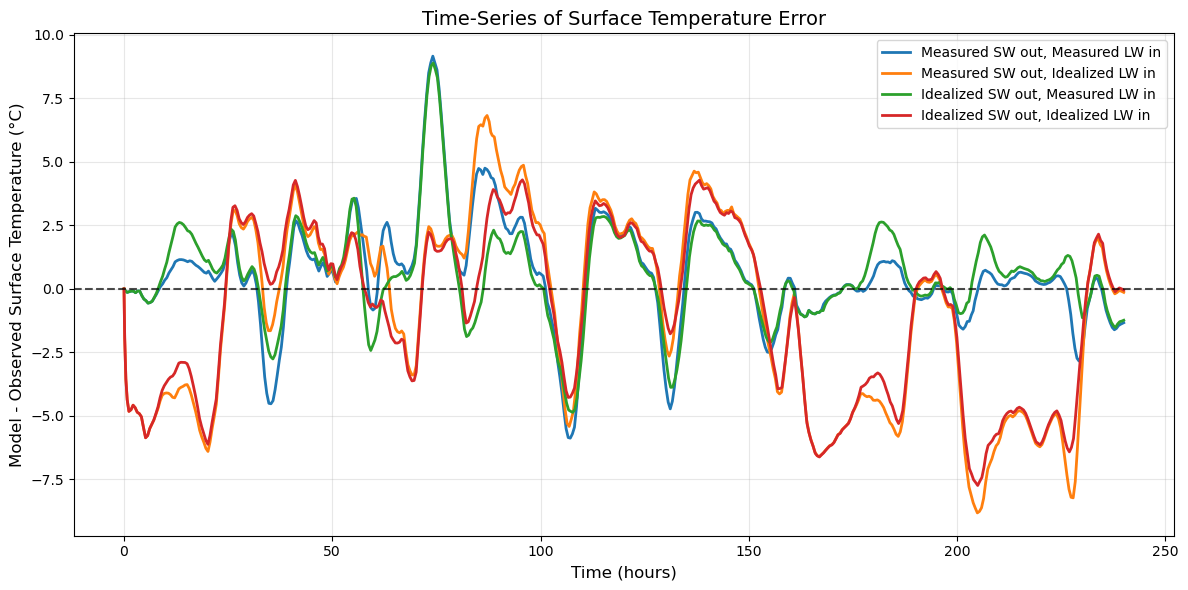

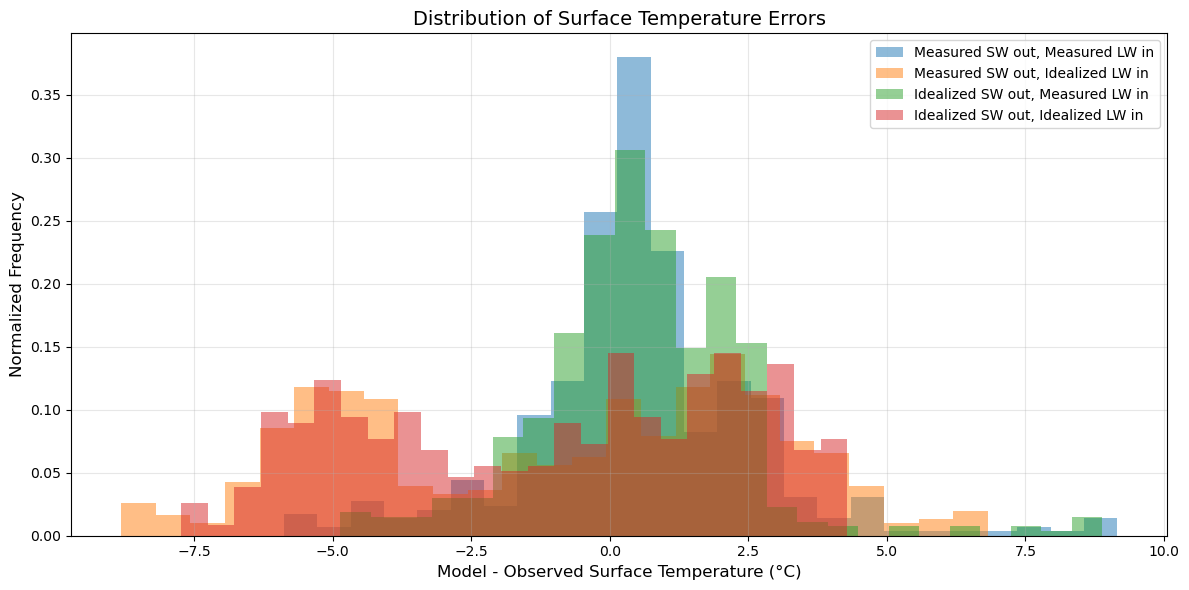

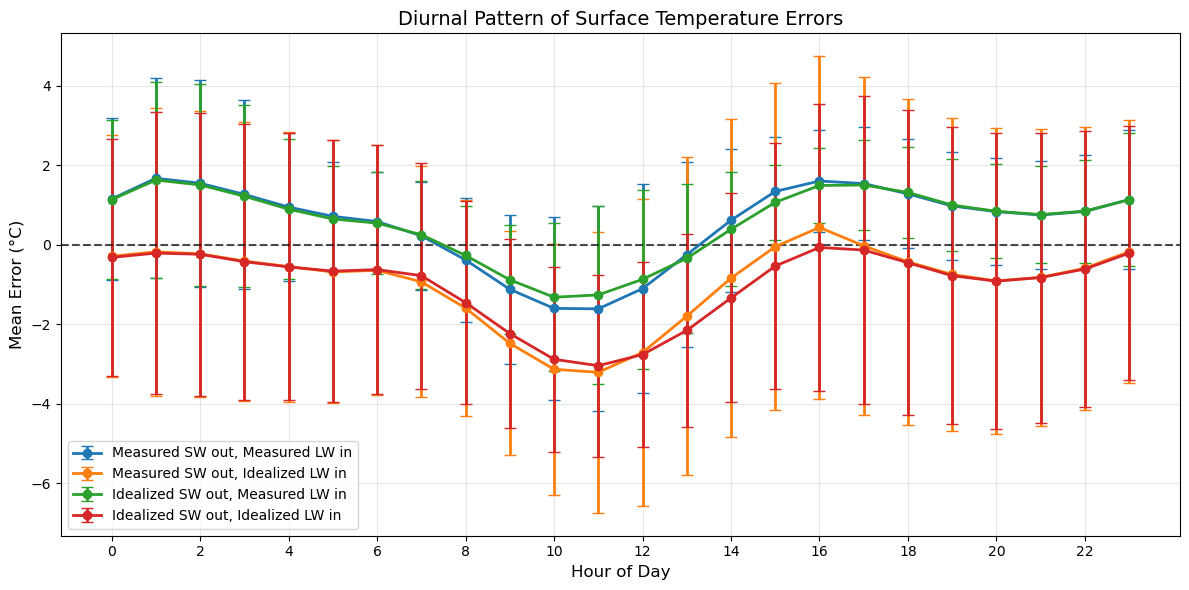

SCENARIO                               MAE   RMSE   BIAS   CORR  DAY Δ  NIGHT Δ
Measured SW out, Measured LW in       1.51   2.18   0.55  0.945  -0.01     1.10
Measured SW out, Idealized LW in      3.25   3.85  -0.95  0.820  -1.41    -0.49
Idealized SW out, Measured LW in      1.41   1.96   0.55  0.957   0.02     1.08
Idealized SW out, Idealized LW in     2.90   3.45  -1.00  0.860  -1.50    -0.51


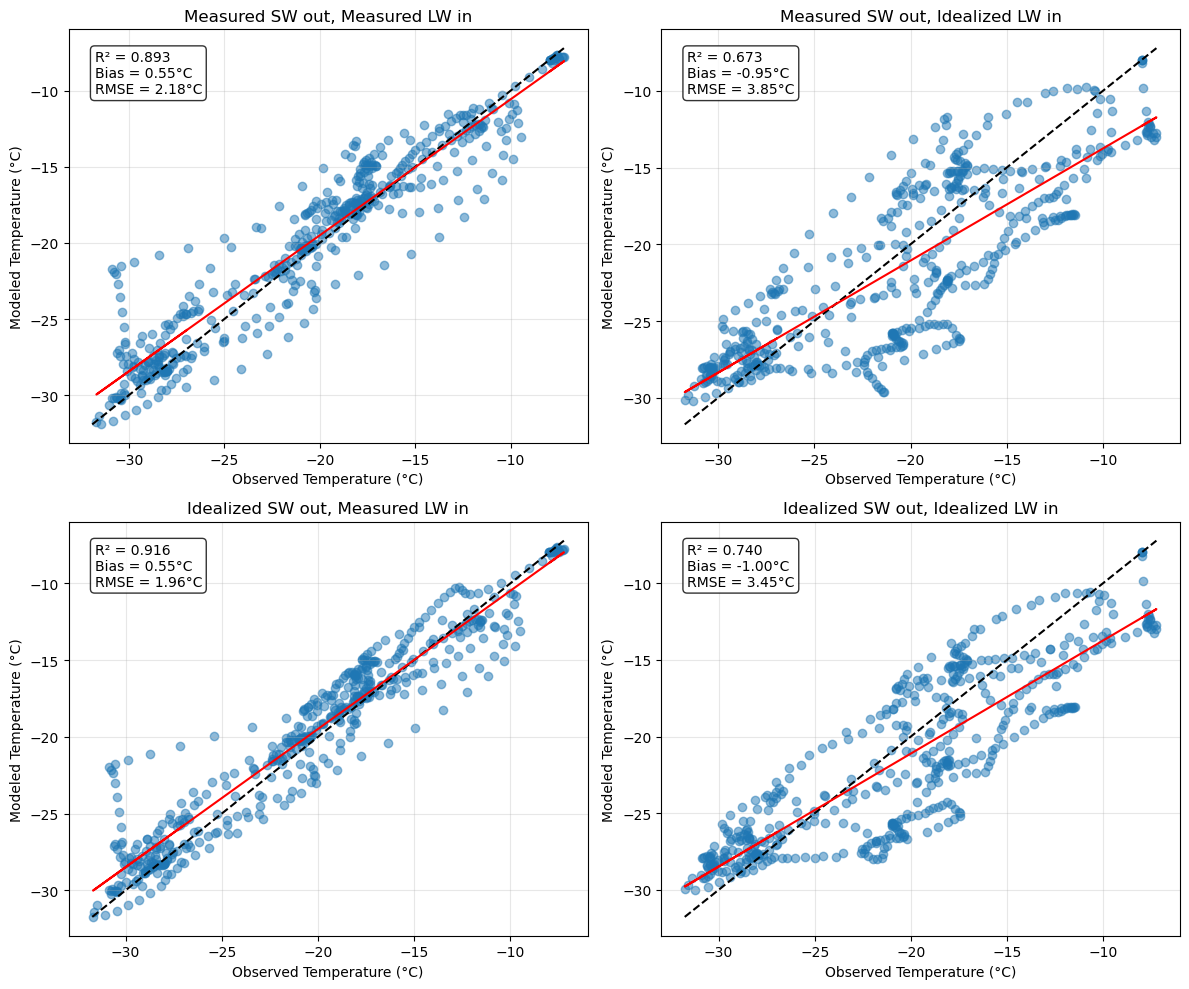

In [11]:
# Define a function for error analysis
def analyze_model_errors(results, observed_data_function):
    # analyze model errors compared to the observed surface temp
    scenario_errors = {}
    scenario_stats = {}
    
    for label, data in results.items():
        # Extract data
        t_model = data['time_sec']
        T_surf_C = data['T_layers'][-1, :] - 273.15
        obs_surf_tempC = observed_data_function(t_model)
        error = T_surf_C - obs_surf_tempC
        
        # Store time series data
        scenario_errors[label] = {
            'time_sec': t_model,
            'error': error,
            'observed': obs_surf_tempC,
            'modeled': T_surf_C
        }
        
        # Calculate metrics
        mae = np.mean(np.abs(error))
        rmse = np.sqrt(np.mean(error**2))
        bias = np.mean(error)
        correlation = np.corrcoef(obs_surf_tempC, T_surf_C)[0,1]
        
        # Day/night analysis
        hours = [(t % (24*3600))/3600 for t in t_model]
        day_mask = np.array([(6 <= h <= 18) for h in hours])
        night_mask = ~day_mask
        
        day_bias = np.mean(error[day_mask]) if np.any(day_mask) else np.nan
        night_bias = np.mean(error[night_mask]) if np.any(night_mask) else np.nan
        
        # Store statistics
        scenario_stats[label] = {
            'MAE': mae,
            'RMSE': rmse,
            'Bias': bias,
            'Correlation': correlation,
            'Day Bias': day_bias,
            'Night Bias': night_bias
        }
    
    return scenario_errors, scenario_stats

def plot_error_timeseries(scenario_errors):
    # Plot time series of errors for each scenario.
    plt.figure(figsize=(12, 6))
    
    for label, data in scenario_errors.items():
        time_hrs = data['time_sec'] / 3600.0
        error = data['error']
        plt.plot(time_hrs, error, label=label, linewidth=2)

    plt.axhline(0, color='k', linestyle='--', alpha=0.7)
    plt.xlabel("Time (hours)", fontsize=12)
    plt.ylabel("Model - Observed Surface Temperature (°C)", fontsize=12)
    plt.title("Time-Series of Surface Temperature Error", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    
    return plt.gcf()

def plot_error_histogram(scenario_errors):
    # Plot histogram of errors for each scenario 
    plt.figure(figsize=(12, 6))
    
    for label, data in scenario_errors.items():
        error = data['error']
        plt.hist(error, bins=25, alpha=0.5, label=label, density=True)

    plt.xlabel("Model - Observed Surface Temperature (°C)", fontsize=12)
    plt.ylabel("Normalized Frequency", fontsize=12)
    plt.title("Distribution of Surface Temperature Errors", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    
    return plt.gcf()

def plot_diurnal_errors(scenario_errors):
    # Plot errors by hour of day to visualize diurnal patterns
    plt.figure(figsize=(12, 6))
    
    for label, data in scenario_errors.items():
        times = data['time_sec']
        hours = [(t % (24*3600))/3600 for t in times]
        error = data['error']
        
        # Group by hour
        hour_bins = np.arange(25)
        hour_indices = np.digitize(hours, hour_bins) - 1
        hourly_errors = [[] for _ in range(24)]
        
        for h_idx, err in zip(hour_indices, error):
            if 0 <= h_idx < 24:
                hourly_errors[h_idx].append(err)
        
        # Calculate mean and std for each hour
        hour_means = [np.mean(errs) if errs else np.nan for errs in hourly_errors]
        hour_stds = [np.std(errs) if len(errs) > 1 else 0 for errs in hourly_errors]
        
        # Plot with error bars
        plt.errorbar(np.arange(24), hour_means, yerr=hour_stds, 
                    label=label, fmt='o-', capsize=4, linewidth=2)

    plt.axhline(0, color='k', linestyle='--', alpha=0.7)
    plt.xlabel("Hour of Day", fontsize=12)
    plt.ylabel("Mean Error (°C)", fontsize=12)
    plt.title("Diurnal Pattern of Surface Temperature Errors", fontsize=14)
    plt.xticks(np.arange(0, 24, 2))
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    
    return plt.gcf()

def display_error_stats_table(scenario_stats):
    # Display a table of error statistics.
    header = f"{'SCENARIO':<35} {'MAE':>6} {'RMSE':>6} {'BIAS':>6} {'CORR':>6} {'DAY Δ':>6} {'NIGHT Δ':>8}"
    separator = "=" * len(header)
    
    print(header)
    print(separator)
    
    # Print rows
    for label, stats in scenario_stats.items():
        print(f"{label:<35} {stats['MAE']:6.2f} {stats['RMSE']:6.2f} {stats['Bias']:6.2f} "
              f"{stats['Correlation']:6.3f} {stats['Day Bias']:6.2f} {stats['Night Bias']:8.2f}")
    
    print(separator)

# Run error analysis
scenario_errors, scenario_stats = analyze_model_errors(results, surf_temp_obs_interp)

# Create visualizations
error_timeseries_fig = plot_error_timeseries(scenario_errors)
plt.show()

error_histogram_fig = plot_error_histogram(scenario_errors)
plt.show()

diurnal_error_fig = plot_diurnal_errors(scenario_errors)
plt.show()

# Display statistics table
display_error_stats_table(scenario_stats)

# Create scatter plot of observed vs modeled temperatures
plt.figure(figsize=(12, 10))

for i, (label, data) in enumerate(scenario_errors.items()):
    plt.subplot(2, 2, i+1)
    
    observed = data['observed']
    modeled = data['modeled']
    
    # Plot scatter with perfect fit line
    plt.scatter(observed, modeled, alpha=0.5)
    
    # Add 1:1 line
    min_val = min(np.min(observed), np.min(modeled))
    max_val = max(np.max(observed), np.max(modeled))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--')
    
    # Add regression line
    z = np.polyfit(observed, modeled, 1)
    p = np.poly1d(z)
    plt.plot(observed, p(observed), 'r-')
    
    rmse = np.sqrt(np.mean((modeled - observed)**2))
    
    # Add stats text
    r2 = np.corrcoef(observed, modeled)[0,1]**2
    bias = np.mean(modeled - observed)
    plt.text(0.05, 0.95, f"R² = {r2:.3f}\nBias = {bias:.2f}°C\nRMSE = {rmse:.2f}°C", 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.title(label)
    plt.xlabel("Observed Temperature (°C)")
    plt.ylabel("Modeled Temperature (°C)")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Animating Temperature Profiles for All Scenarios

If generate_animation = True, this creates a single plot with four scenario profiles over time as a gif. 


Created time array with 486 points
Created depth array with 35 points


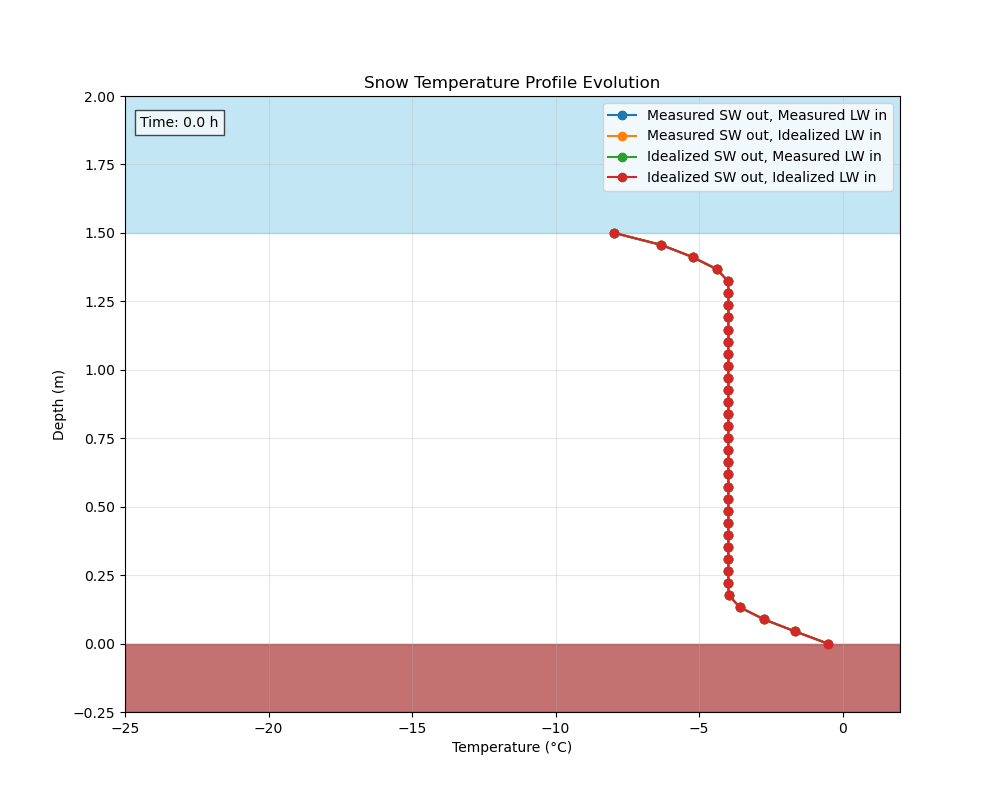

In [12]:
# Create a gif animation with all four scenarios on the same plot

if generate_animation:
    # Create a single figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create a line for each scenario with the same colors as your previous plots
    lines = []
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] 
    for i, (label, _) in enumerate(scenarios.items()):
        line, = ax.plot([], [], '-o', color=colors[i], label=label)
        lines.append(line)
    
    # Get time array from first scenario's results
    first_scenario = list(results.values())[0]
    time = first_scenario.get('time', None)
    z_T = first_scenario.get('z_T', None)
    
    # Check if time and z_T are available
    if time is None or z_T is None:
        if 'T_layers' in first_scenario and hasattr(first_scenario['T_layers'], 'shape'):
            time_dim = first_scenario['T_layers'].shape[1]
            time = np.linspace(0, time_dim * 3600, time_dim)
            print(f"Created time array with {time_dim} points")
            
            if z_T is None and 'H' in globals():
                layer_count = first_scenario['T_layers'].shape[0]
                z_T = np.linspace(0, H, layer_count)
                print(f"Created depth array with {layer_count} points")
    
    if time is None:
        print("Error: Could not find time data in results")
        plt.close()
        
    else:
        # Add timestamp text
        time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, 
                          bbox=dict(facecolor='white', alpha=0.7))
        
        def init_anim():
            ax.set_xlim(-25, 2)
            ax.set_ylim(-0.25, H+0.5)
            ax.set_xlabel("Temperature (°C)")
            ax.set_ylabel("Depth (m)")
            ax.set_title("Snow Temperature Profile Evolution")
            ax.grid(True, alpha=0.3)
            ax.axhspan(-0.25, 0, color='brown', alpha=0.3)
            ax.axhspan(H, H+0.5, color='skyblue', alpha=0.2)
            ax.legend(loc='upper right')
            return lines + [time_text]
        
        def animate(frame):
            total_frames = 50
            idx = min(int(frame * len(time) / total_frames), len(time)-1)
            hrs = time[idx]/3600
            
            time_text.set_text(f'Time: {hrs:.1f} h')
            
            for j, (label, _) in enumerate(scenarios.items()):
                T_layers = results[label]['T_layers']
                if idx < T_layers.shape[1]:
                    T_s = T_layers[:, idx]-273.15
                    lines[j].set_data(T_s, z_T)
            
            return lines + [time_text]
        
        try:
            ani = FuncAnimation(fig, animate, frames=50,
                              init_func=init_anim, interval=100, blit=True)
            
            ani.save('temperature_profile_evolution_all_scenarios.gif', 
                    writer='pillow', fps=5)
            plt.close()
            
            display(Image('temperature_profile_evolution_all_scenarios.gif'))
            
        except Exception as e:
            print(f"Error creating animation: {str(e)}")
            plt.close()
else:
    print("Animation generation skipped.")

## Plot contour maps of temperature profiles 

Generate contour plots of heat over time for the scenarios, highlighting temp gradient direction and severe temp gradients. Experimenting for future versions of the model to learn about metamorphism. 


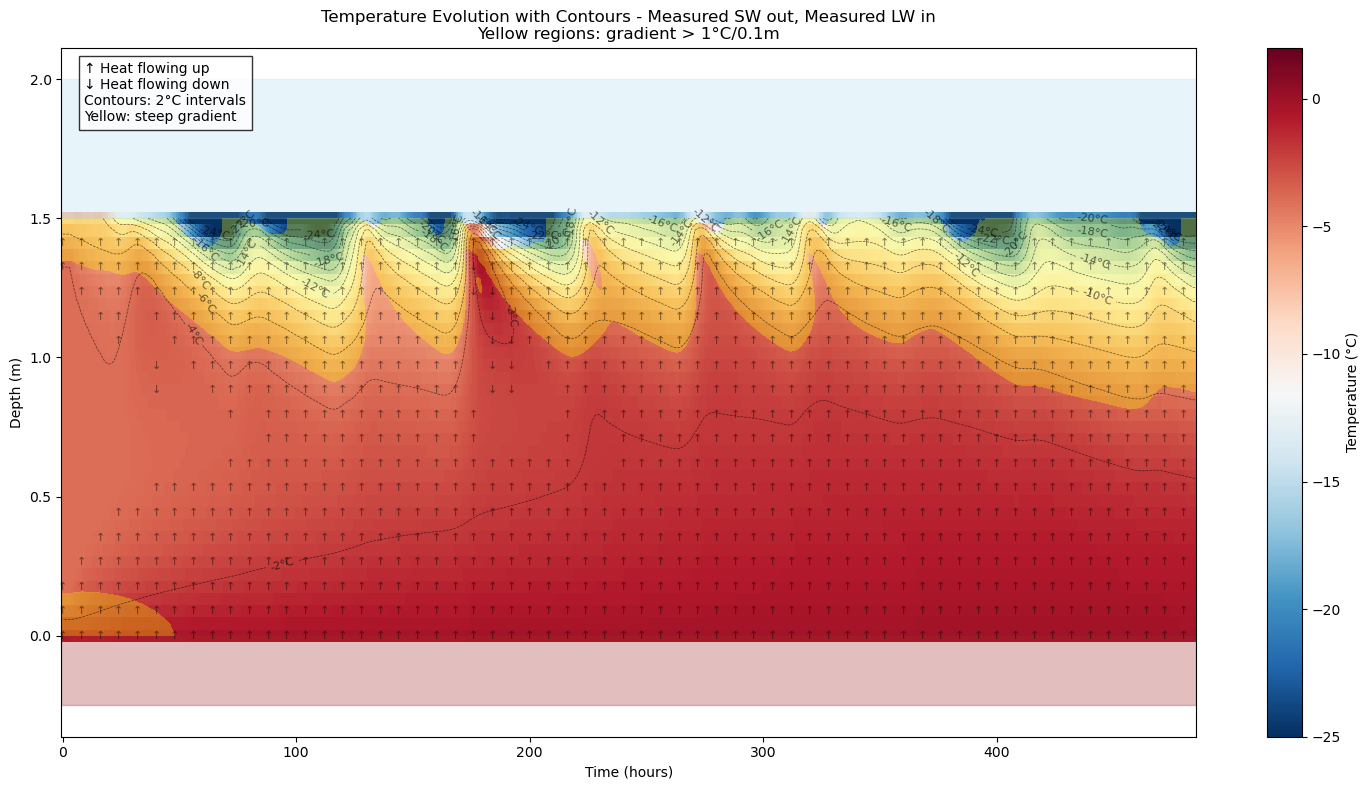

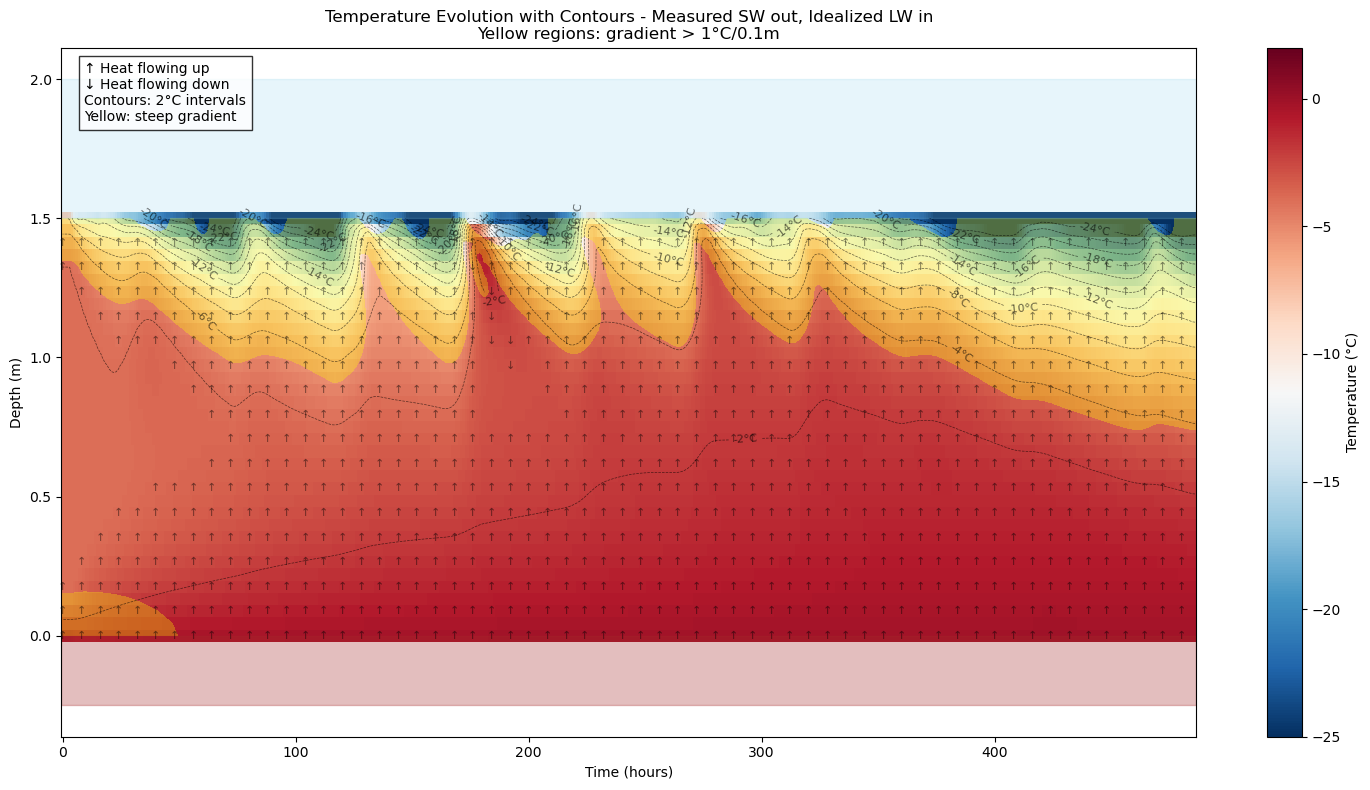

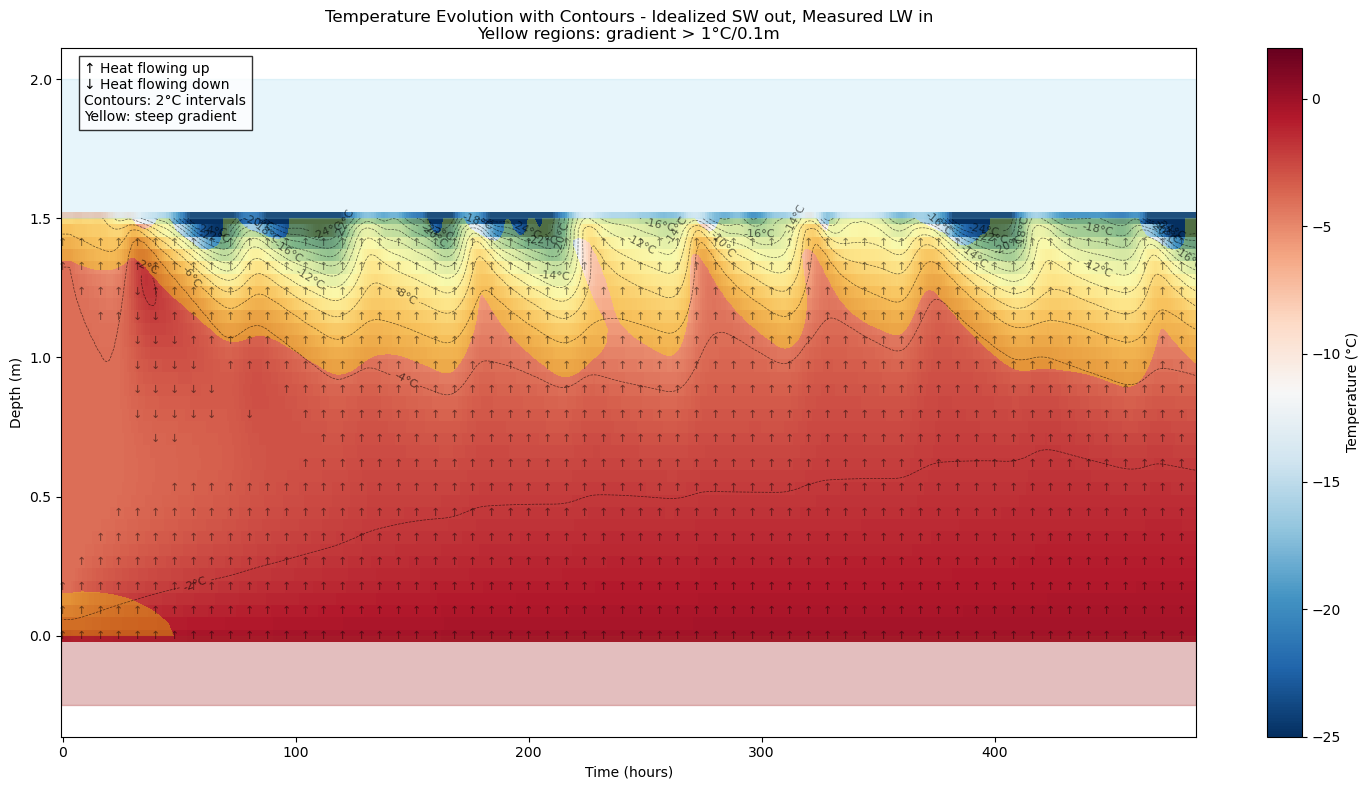

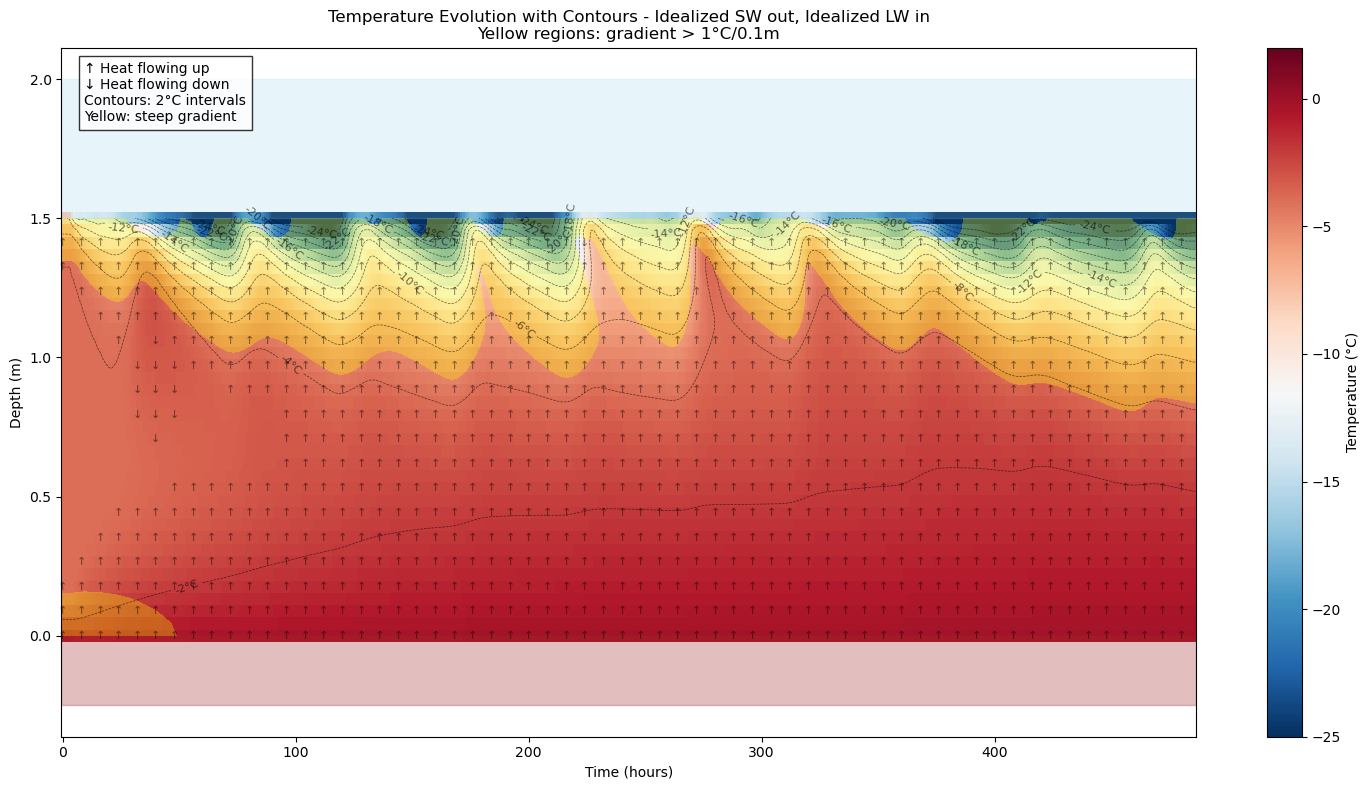

In [13]:
# Create time series heat map with contours and heat flow indicators
def plot_temp_heatmap_with_contours(results, scenarios, H):
    for scenario_label, scenario_data in results.items():
        # Get temperature data and convert to Celsius
        T_layers = scenario_data['T_layers'] - 273.15
        
        # Create time array (in hours)
        time_hrs = np.arange(T_layers.shape[1]) * 1  # Assuming 1 hour intervals
        
        # Create depth array
        z_points = np.linspace(0, H, T_layers.shape[0])
        
        # Create meshgrid for plotting
        T, Z = np.meshgrid(time_hrs, z_points)
        
        # Calculate temperature gradients
        dT_dz = np.gradient(T_layers, z_points, axis=0)  # Spatial gradient (°C/m)
        
        # Create figure
        fig, ax = plt.subplots(figsize=(15, 8))
        
        # Plot heatmap
        heatmap = ax.pcolormesh(T, Z, T_layers, 
                               cmap='RdBu_r', 
                               shading='auto',
                               vmin=-25, vmax=2)
        
        # Add temperature contours
        contour_levels = np.arange(-24, 2, 2)  # Contour every 2°C
        contours = ax.contour(T, Z, T_layers, 
                            levels=contour_levels,
                            colors='black',
                            linewidths=0.5,
                            alpha=0.6)
        ax.clabel(contours, inline=True, fontsize=8, fmt='%1.0f°C')
        
        # Highlight regions with steep gradients (>10°C/m or 1°C/0.1m)
        steep_gradient_mask = np.abs(dT_dz) > 10
        if np.any(steep_gradient_mask):
            ax.contourf(T, Z, np.abs(dT_dz), 
                       levels=[10, 100],  # Highlight gradients >10°C/m
                       colors=['yellow'],
                       alpha=0.3)
        
        # Plot simple direction arrows (more sparsely distributed)
        time_skip = 8
        depth_skip = 2
        
        for t_idx in range(0, T_layers.shape[1], time_skip):
            for z_idx in range(0, T_layers.shape[0]-1, depth_skip):
                gradient = -dT_dz[z_idx, t_idx]  # Negative for heat flow direction
                
                # Only plot arrows where there's a significant gradient
                if abs(gradient) > 1:  # Show arrows for gradients > 1°C/m
                    direction = '↑' if gradient > 0 else '↓'
                    ax.text(time_hrs[t_idx], z_points[z_idx], direction,
                           ha='center', va='center',
                           color='black', alpha=0.5,
                           fontsize=8)
        
        # Add colorbar
        cbar = plt.colorbar(heatmap)
        cbar.set_label('Temperature (°C)')
        
        # Customize plot
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel('Depth (m)')
        ax.set_title(f'Temperature Evolution with Contours - {scenario_label}\nYellow regions: gradient > 1°C/0.1m')
        
        # Add ground and air indicators
        ax.axhspan(-0.25, 0, color='brown', alpha=0.3, label='Ground')
        ax.axhspan(H, H+0.5, color='skyblue', alpha=0.2, label='Air')
        # Add legend for arrows
        ax.text(0.02, 0.98, '↑ Heat flowing up\n↓ Heat flowing down\nContours: 2°C intervals\nYellow: steep gradient',
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top', 
                horizontalalignment='left',
                bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

# Plot heatmaps for each scenario
plot_temp_heatmap_with_contours(results, scenarios, H)